In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from scipy import stats
from datetime import datetime, timedelta
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from IPython.display import display as dsp

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

# United States Drug Prices: Forecasting and Analysis

## Abstract

We want to explore and describe the US drug market, both in terms of general trends and the price of individual drugs on the market. The purpose of this analysis is to explore what features contribute to the 

## Data Collection

In [2]:
#Socrata SQL query
SODA = '$limit=500000'
#SODA = '$limit=50000000'
URL = 'https://data.medicaid.gov/resource/444w-ftrz.csv?{}'.format(SODA)

TRAIN_SPLIT = 0.8

In [3]:
def list_unique_counts(df):
    column_name, unique_values_count, datatype = [], [], []
    results = pd.DataFrame()
    for col in df.columns:
        #print(col, '\t\t\t', len(df[str(col)].unique()))
        column_name.append(col)
        unique_values_count.append(len(df[str(col)].unique()))
        datatype.append(df[str(col)].dtype)
    
    results['Column_Name'] = column_name
    results['Unique_Value_Count'] = unique_values_count
    results['Data_Type'] = datatype
    
    dsp(results)
    print('Total Number of Changes: {}'.format(df.shape[0]))
    
    print('Total Number Observations: ', df.shape[0])

def train_split(df, TRAIN_SPLIT):
    split_point = int(len(df) * (TRAIN_SPLIT))
    train = df[:split_point]
    test = df[split_point:]
    return train, test

def strip_time(date):
    date = date.replace('T00:00:00.000', '')
    return datetime.strptime(date, '%Y-%m-%d')

def return_name(ndc_description):
    if len(ndc_description) == 0:
        return '','','',''
    drug_name, dosage, dosage_unit, drug_form = [], np.nan, np.nan, np.nan
    
    #Check and see if we are dealing with concentration
    concentration = False
    if set('%') <= set(ndc_description):
        concentration = True
        ndc_description.replace('%', '')
    
    #Create our array of words
    words = ndc_description.split()
    
    for i in range(len(words)):
        if not words[i].replace('.','').replace('%', '').isnumeric():
            drug_name.append(words[i])
            
        if words[i].replace('.','').replace('%','').isnumeric():
            dosage = float(words[i].replace('%', ''))
            
            if not concentration:
                try:
                    dosage_unit = words[i + 1]
                    drug_form = ' '.join(words[i + 2:])
                except:
                    drug_form = ' '.join(words[i:])
                    #print(ndc_description, concentration)
                break
            
            if concentration:
                dosage_unit = 'concentration'
                drug_form = ' '.join(words[i + 1:])
                break
            
    drug_name = ' '.join(drug_name)
    return pd.Series([drug_name, dosage, dosage_unit, drug_form])

def drop_na_printout(dataframe):
    i = dataframe.shape[0]
    j = dataframe.dropna().shape[0]
    
    percent_loss = (i - j) / i * 100
    
    print(percent_loss, '% data lost in cleaning.')
    
    return dataframe.dropna()

In [4]:
raw = pd.read_csv(URL, parse_dates = True)

#Convert dates to date format
raw['start_date'] = raw['start_date'].apply(lambda x: strip_time(x))
raw['end_date'] = raw['end_date'].apply(lambda x: strip_time(x))

#Remove Effective Date
raw = raw.drop('effective_date', 1)

In [5]:
print(raw.columns)

#Create 'days_effective' and 'day_count' columns
raw['days_effective'] = (raw['end_date'] - raw['start_date'])
raw['days_effective'] = raw['days_effective'].apply(lambda x: x.days)

raw['days_count'] = (raw['start_date'] - min(raw['start_date']))
raw['days_count'] = raw['days_count'].apply(lambda x: x.days)

#Create 'month-year' column because most changes happen in the middle of every month
raw['year-month'] = raw['start_date'].apply(lambda x: x.strftime('%Y-%m'))

#Add drug name column, we want to ignore dosage and format
raw[['drug_name', 'dosage','dosage_unit','drug_form']] = \
raw['ndc_description'].apply(lambda x: return_name(x))
    
#Remove all first-date entries
if len(raw['start_date'].unique()) > 1:
    raw.drop(raw[raw['start_date'] == min(raw['start_date'])].index, inplace = True)

#Remove last month of data, this is typically truncated by the limitations of our API call
if len(raw['year-month']) > 3:
    raw.drop(raw[raw['year-month'] == max(raw['year-month'])].index, inplace = True)

dsp(raw.head())

Index(['ndc_description', 'ndc', 'old_nadac_per_unit', 'new_nadac_per_unit',
       'classification_for_rate_setting', 'percent_change', 'primary_reason',
       'start_date', 'end_date'],
      dtype='object')


,ndc_description,ndc,old_nadac_per_unit,new_nadac_per_unit,classification_for_rate_setting,percent_change,primary_reason,start_date,end_date,days_effective,days_count,year-month,drug_name,dosage,dosage_unit,drug_form
24,ALREX 0.2% EYE DROPS,24208035305,27.08802,29.52622,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS
25,ALREX 0.2% EYE DROPS,24208035310,27.39300,29.85892,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS
26,ATIVAN 0.5 MG TABLET,64455006301,4.35697,5.06236,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,0.5,MG,TABLET
27,ATIVAN 1 MG TABLET,64455006401,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET
28,ATIVAN 1 MG TABLET,64455006410,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET


In [6]:
#old_nadac_per_unit, new_nadac_per_unit, classification_for_rate_setting, percent_change, primary_reason, year-month
#drug_name, dosage, dosage_unit, drug_form

In [7]:
raw = drop_na_printout(raw)

13.085503719321077 % data lost in cleaning.


In [8]:
#Scale price to dosage
raw['daily_max_dosage'] = raw.groupby(['drug_name', 'start_date', 'dosage_unit'])['dosage'].transform('max')
raw['scaled_old_per_unit'] = raw['daily_max_dosage'] / raw['dosage'] * raw['old_nadac_per_unit']
raw['scaled_new_per_unit'] = raw['daily_max_dosage'] / raw['dosage'] * raw['new_nadac_per_unit']
raw['scaled_percent_change'] = (raw['scaled_new_per_unit'] - raw['scaled_old_per_unit']) \
/ raw['scaled_old_per_unit'] * 100

In [9]:
raw.head()

,ndc_description,ndc,old_nadac_per_unit,new_nadac_per_unit,classification_for_rate_setting,percent_change,primary_reason,start_date,end_date,days_effective,days_count,year-month,drug_name,dosage,dosage_unit,drug_form,daily_max_dosage,scaled_old_per_unit,scaled_new_per_unit,scaled_percent_change
24,ALREX 0.2% EYE DROPS,24208035305,27.08802,29.52622,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS,0.2,27.08802,29.52622,9.001027
25,ALREX 0.2% EYE DROPS,24208035310,27.39300,29.85892,B,9.00,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ALREX,0.2,concentration,EYE DROPS,0.2,27.39300,29.85892,9.002008
26,ATIVAN 0.5 MG TABLET,64455006301,4.35697,5.06236,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,0.5,MG,TABLET,2.0,17.42788,20.24944,16.189921
27,ATIVAN 1 MG TABLET,64455006401,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET,2.0,11.68548,13.57724,16.188980
28,ATIVAN 1 MG TABLET,64455006410,5.84274,6.78862,B,16.19,WAC Adjustment,2013-12-05,2013-12-11,6,7,2013-12,ATIVAN,1.0,MG,TABLET,2.0,11.68548,13.57724,16.188980


In [10]:
print('Top value counts for NDC:')
dsp(raw['ndc'].value_counts().sort_values(ascending = False).head())

print('\nTop value counts for NDC description:')
dsp(raw['ndc_description'].value_counts().sort_values(ascending = False).head())

Top value counts for NDC:


60505255105    22
51079076508    22
68084062401    22
59762502301    22
68462012601    22
Name: ndc, dtype: int64


Top value counts for NDC description:


METFORMIN HCL 500 MG TABLET      1976
LISINOPRIL 20 MG TABLET          1628
LISINOPRIL 10 MG TABLET          1567
AMLODIPINE BESYLATE 5 MG TAB     1551
AMLODIPINE BESYLATE 10 MG TAB    1508
Name: ndc_description, dtype: int64

### Normalization

In [11]:
#Check correlation between dosage and price witin each drug
top_10 = raw['drug_name'].value_counts().sort_values(ascending = False)[:20].index

In [12]:
#Check correlation between dosage and price within individual drugs
print('Dosage to per-unit price correlation for 10 most changed drugs:\n')
print('(Pearson Correlation Coefficient, P-Value)')
for drug in top_10:
    drug_changelog = raw[raw['drug_name'] == drug]
    print(drug)
    print(stats.pearsonr(drug_changelog['new_nadac_per_unit'].values, drug_changelog['dosage'].values))

Dosage to per-unit price correlation for 10 most changed drugs:

(Pearson Correlation Coefficient, P-Value)
LISINOPRIL
(0.864420129149428, 0.0)
RISPERIDONE
(0.2033609498629652, 5.499571296895248e-52)
GABAPENTIN
(0.8569656229109558, 0.0)
SIMVASTATIN
(0.8618310041791036, 0.0)
AMLODIPINE BESYLATE
(0.7568323175886235, 0.0)
QUETIAPINE FUMARATE
(0.9519636727113635, 0.0)
IBUPROFEN
(0.7836383973226292, 0.0)
METFORMIN HCL
(0.9742844110646679, 0.0)
OLANZAPINE
(0.9801290331139227, 0.0)
CITALOPRAM HBR
(-0.08183624262301034, 4.367269436408418e-06)
LEVETIRACETAM
(0.911590313135831, 0.0)
AMOXICILLIN
(0.5428050462190125, 2.6259675320258957e-234)
CARVEDILOL
(0.42290241643306814, 1.0370271316225878e-131)
LOSARTAN POTASSIUM
(0.8802892558883041, 0.0)
LAMOTRIGINE
(-0.2922914888777595, 1.0232722712910593e-57)
MONTELUKAST SOD
(-0.2681767547853191, 4.2858183401626166e-45)
SERTRALINE HCL
(0.317493212045036, 4.3023427563742916e-62)
PIOGLITAZONE HCL
(0.8569806152381154, 0.0)
ALPRAZOLAM
(0.07107803147447654, 0.00

In [13]:
#Create drugs dataframe
drugs = raw[['drug_name','old_nadac_per_unit','new_nadac_per_unit']].groupby(['drug_name']).mean().rename(
    {'old_nadac_per_unit' : 'old_average_per_unit','new_nadac_per_unit': 'new_average_per_unit'}, axis = 1)
drugs['percent_average_change'] = (drugs['new_average_per_unit'] 
                                   - drugs['old_average_per_unit']) / drugs['new_average_per_unit'] * 100

In [14]:
max_price, min_price, max_dosage = [], [], []
for drug in drugs.index:
    max_price.append(max(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    min_price.append(min(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    max_dosage.append(max(raw[raw['drug_name'] == drug]['dosage']))
drugs['max_per_unit'] = max_price
drugs['min_per_unit'] = min_price
drugs['max_dosage'] = max_dosage
drugs.head()

,old_average_per_unit,new_average_per_unit,percent_average_change,max_per_unit,min_per_unit,max_dosage
drug_name,,,,,,
,0.061608,0.061494,-0.185384,0.06650,0.05932,8.0
12-HR DECONGEST,0.341570,0.342896,0.386823,0.37681,0.32264,120.0
ABACAVIR,4.303600,4.246232,-1.351048,6.13318,3.09071,300.0
ABILIFY,28.790676,30.332430,5.082858,40.98323,5.50154,30.0
ABILIFY DISCMELT,30.165025,34.659615,12.967801,35.01615,34.30308,15.0


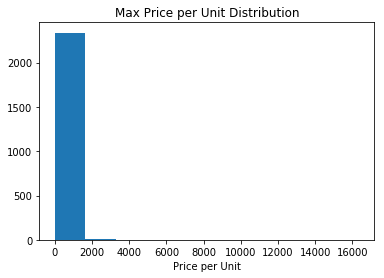

In [15]:
plt.title('Max Price per Unit Distribution')
#drugs[(np.abs(stats.zscore(drugs)) < 1).all(axis=1)]
plt.hist(drugs['max_per_unit'])

plt.xlabel('Price per Unit')
plt.show()

## Exploratory Data Analysis

### Metadata

In [16]:
print('\nUnique Values in Raw Data per Column:')
list_unique_counts(raw)


Unique Values in Raw Data per Column:


,Column_Name,Unique_Value_Count,Data_Type
0,ndc_description,4787,object
1,ndc,41876,object
2,old_nadac_per_unit,49345,float64
3,new_nadac_per_unit,49387,float64
4,classification_for_rate_setting,2,object
5,percent_change,6081,float64
6,primary_reason,4,object
7,start_date,107,datetime64[ns]
8,end_date,107,datetime64[ns]
9,days_effective,2,int64


Total Number of Changes: 416775
Total Number Observations:  416775


### Data Distribution

In [17]:
data = raw[['drug_name','start_date', 'days_count', 'year-month', 'old_nadac_per_unit', 'new_nadac_per_unit', 'scaled_old_per_unit',\
          'scaled_new_per_unit', 'percent_change', 'scaled_percent_change']]

#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_out_rm = data[(np.abs(stats.zscore(data[['percent_change']])) < 3).all(axis = 1)]

#### Percent Change

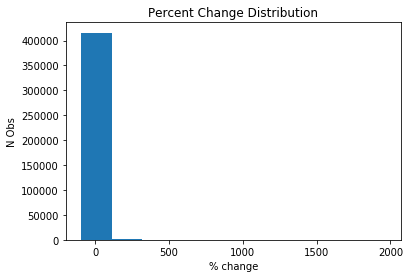

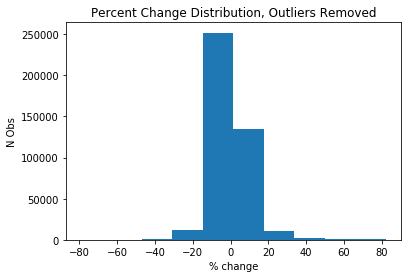

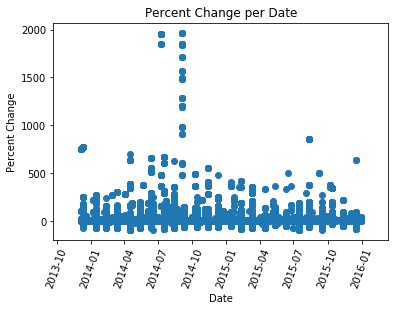

In [18]:
plt.title('Percent Change Distribution')
plt.hist(data['percent_change'])
plt.xlabel('% change')
plt.ylabel('N Obs')
plt.show()

plt.title('Percent Change Distribution, Outliers Removed')
plt.hist(data_out_rm['percent_change'])
plt.xlabel('% change')
plt.ylabel('N Obs')
plt.show()

plt.title('Percent Change per Date')
plt.scatter(data['start_date'], data['percent_change'])
plt.xticks(rotation = 70)
plt.xlabel('Date')
plt.ylabel('Percent Change')

plt.show()

In [19]:
raw.sort_values('percent_change', ascending = False)[:10].head()

,ndc_description,ndc,old_nadac_per_unit,new_nadac_per_unit,classification_for_rate_setting,percent_change,primary_reason,start_date,end_date,days_effective,days_count,year-month,drug_name,dosage,dosage_unit,drug_form,daily_max_dosage,scaled_old_per_unit,scaled_new_per_unit,scaled_percent_change
168521,CLOBETASOL 0.05% GEL,45802092596,0.26027,5.37913,G,1966.75,Help Desk,2014-09-03,2014-09-10,7,279,2014-09,CLOBETASOL,0.05,concentration,GEL,0.05,0.26027,5.37913,1966.749914
168518,CLOBETASOL 0.05% GEL,168029360,0.26027,5.37913,G,1966.75,Help Desk,2014-09-03,2014-09-10,7,279,2014-09,CLOBETASOL,0.05,concentration,GEL,0.05,0.26027,5.37913,1966.749914
168524,CLOBETASOL 0.05% GEL,50383026960,0.26027,5.37913,G,1966.75,Help Desk,2014-09-03,2014-09-10,7,279,2014-09,CLOBETASOL,0.05,concentration,GEL,0.05,0.26027,5.37913,1966.749914
168527,CLOBETASOL 0.05% GEL,51672129403,0.26027,5.37913,G,1966.75,Help Desk,2014-09-03,2014-09-10,7,279,2014-09,CLOBETASOL,0.05,concentration,GEL,0.05,0.26027,5.37913,1966.749914
130769,AMITRIPTYLINE HCL 50 MG TAB,378265001,0.02242,0.45975,G,1950.62,Help Desk,2014-07-09,2014-07-16,7,223,2014-07,AMITRIPTYLINE HCL,50.00,MG,TAB,150.00,0.06726,1.37925,1950.624442


#### Price per Unit: de facto and scaled

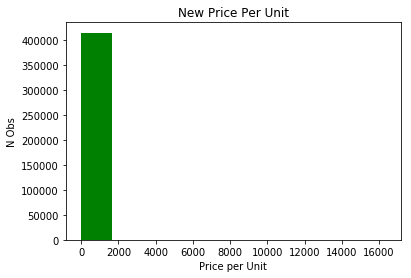

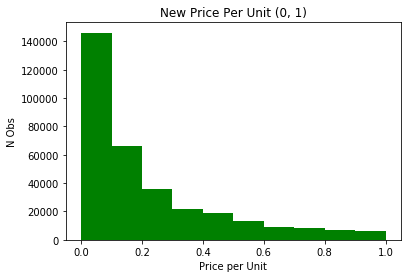

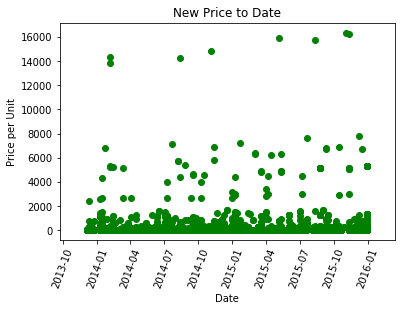

In [20]:
plt.title('New Price Per Unit')
plt.hist(data_out_rm['new_nadac_per_unit'], color = 'green')
plt.xlabel('Price per Unit')
plt.ylabel('N Obs')
plt.show()

plt.title('New Price Per Unit (0, 1)')
plt.hist(data['new_nadac_per_unit'], range = (0, 1), color = 'green')
plt.xlabel('Price per Unit')
plt.ylabel('N Obs')
plt.show()

plt.title('New Price to Date')
plt.scatter(data['start_date'], data['new_nadac_per_unit'], color = 'green')
plt.xticks(rotation = 70)
plt.xlabel('Date')
plt.ylabel('Price per Unit')
plt.show()

#Price Differential
#Remove Outliers

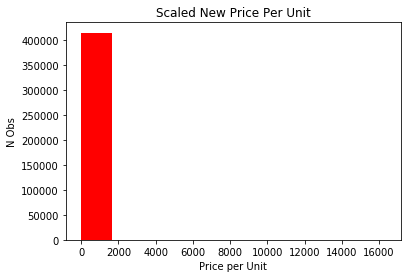

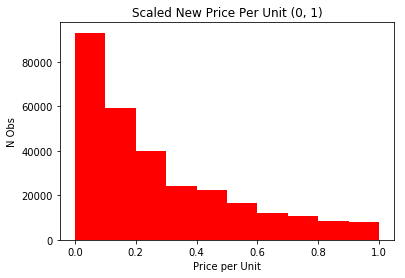

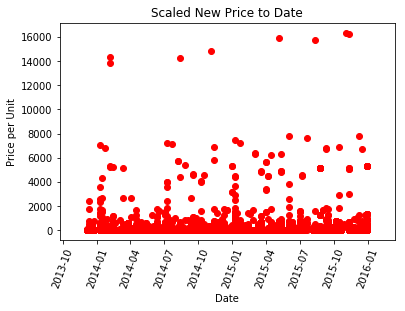

In [21]:
plt.title('Scaled New Price Per Unit')
plt.hist(data_out_rm['scaled_new_per_unit'], color = 'red')
plt.xlabel('Price per Unit')
plt.ylabel('N Obs')
plt.show()

plt.title('Scaled New Price Per Unit (0, 1)')
plt.hist(data['scaled_new_per_unit'], range = (0, 1), color = 'red')
plt.xlabel('Price per Unit')
plt.ylabel('N Obs')
plt.show()

plt.title('Scaled New Price to Date')
plt.scatter(data['start_date'], data['scaled_new_per_unit'], color = 'red')
plt.xticks(rotation = 70)
plt.xlabel('Date')
plt.ylabel('Price per Unit')
plt.show()

#Overlap Scaled and raw
#Don't hard code the range

#### Correlation Testing

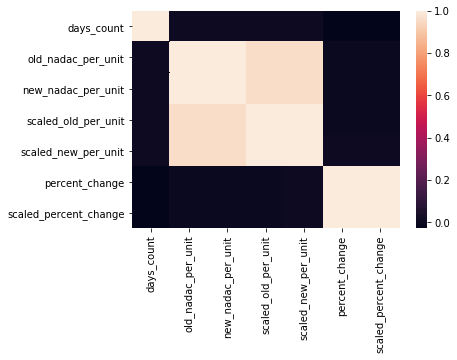

In [22]:
sns.heatmap(data.corr())

#SAmple of drugs
#Test correlation of rates of change

### Metrics for General Volatility

#### Changes per Day

In [23]:
#Changes per day
change_count = raw['start_date'].value_counts().sort_index()
dsp(change_count.head())

print('Our data represents the range of dates between {} and {}'.format(change_count.index.min().strftime('%Y-%m-%d'),
                                                                        change_count.index.max().strftime('%Y-%m-%d')))

2013-12-05      105
2013-12-11    15729
2013-12-18       61
2013-12-25       11
2014-01-08      318
Name: start_date, dtype: int64

Our data represents the range of dates between 2013-12-05 and 2015-12-30


In [24]:
print(change_count.sort_values(ascending = False)[:10])

2015-12-16    17269
2015-11-11    17249
2015-07-15    16932
2015-10-14    16918
2015-06-10    16859
2015-02-11    16763
2015-08-12    16731
2015-05-13    16719
2014-11-12    16693
2015-04-15    16626
Name: start_date, dtype: int64


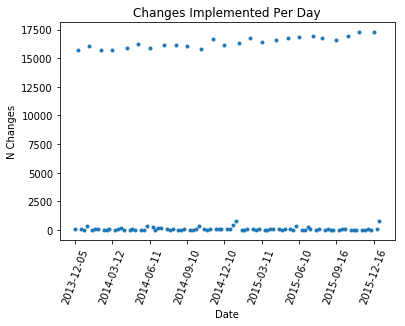

In [25]:
plt.title('Changes Implemented Per Day')
plt.plot(change_count.index.strftime('%Y-%m-%d'), change_count.values, '.')
plt.xticks(np.arange(0,len(change_count.index), round((len(change_count.index)) / 8)), rotation = 70)
plt.xlabel('Date')
plt.ylabel('N Changes')
plt.show()

##### What kind of changes happen at what times.

In [26]:
#Group dates into high-change days or low change days
CHANGE_LIMIT = 10000

#Add Feature in raw df
#raw['volume'] = np.where()

#### Changes per Month

In [27]:
mnth_count = raw['year-month'].value_counts().sort_index()
mnth_count.head()

2013-12    15906
2014-01    16419
2014-02    15824
2014-03    15864
2014-04    16187
Name: year-month, dtype: int64

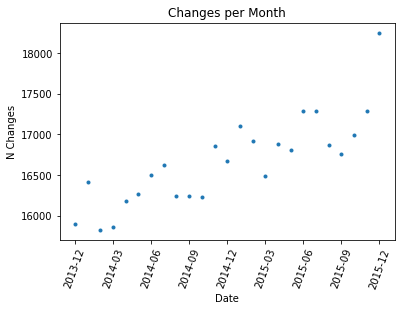

In [28]:
plt.title('Changes per Month')
plt.plot(mnth_count, '.')
plt.xticks(np.arange(0,len(mnth_count.index), round((len(mnth_count.index)) / 8)), rotation = 70)
plt.xlabel('Date')
plt.ylabel('N Changes')
plt.show()

#### Average Rate Change per Month

In [29]:
mnth_avgs = raw.groupby(['year-month']).mean()
mnth_avgs.head()

,old_nadac_per_unit,new_nadac_per_unit,percent_change,days_effective,days_count,dosage,daily_max_dosage,scaled_old_per_unit,scaled_new_per_unit,scaled_percent_change
year-month,,,,,,,,,,
2013-12,1.833895,1.896660,5.073839,6.993399,12.996919,108.309114,157.827054,2.732459,2.836470,5.073551
2014-01,3.760482,3.888046,7.562463,7.000000,47.923686,106.965057,155.738260,5.454216,5.651314,7.569508
2014-02,4.357223,4.487732,-2.906283,7.000000,76.014156,107.657281,156.850228,5.106859,5.221174,-2.906400
2014-03,2.195605,2.222135,0.376311,7.000000,103.998676,107.128001,155.644765,3.240518,3.299216,0.364178
2014-04,1.888697,1.899964,0.199421,7.000000,138.861617,107.159301,155.792940,2.822958,2.839127,0.201176


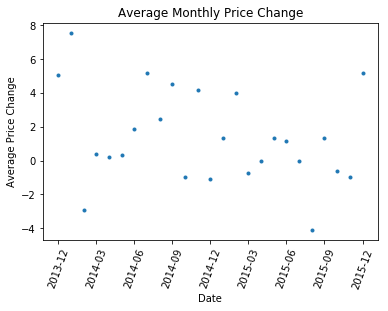

In [30]:
plt.title('Average Monthly Price Change')
plt.plot(mnth_avgs['percent_change'], '.')
plt.xticks(np.arange(0,len(mnth_avgs.index), round((len(mnth_avgs.index)) / 8)), rotation = 70)
plt.xlabel('Date')
plt.ylabel('Average Price Change')
plt.show()

Text(0, 0.5, 'Observations')

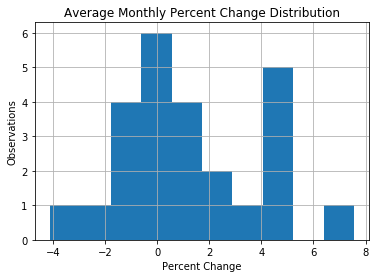

In [31]:
plt.title('Average Monthly Percent Change Distribution')
mnth_avgs['percent_change'].hist()
plt.xlabel('Percent Change')
plt.ylabel('Observations')

#### Total Price Gain/Loss per Month

In [32]:
raw['total_price_change'] = raw['new_nadac_per_unit'] - raw['old_nadac_per_unit']
mnth_sum = raw.groupby(['year-month']).sum()


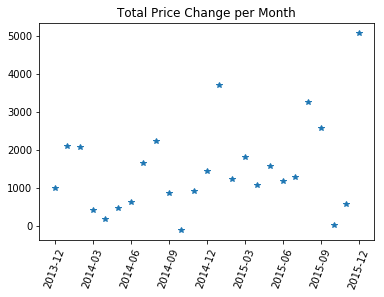

In [33]:
plt.title('Total Price Change per Month')
plt.plot(mnth_sum['total_price_change'], '*')
plt.xticks(np.arange(0,len(mnth_sum.index), round((len(mnth_sum.index)) / 8)), rotation = 70)
plt.show()

In [54]:
#Calculate the correlation within these and their respective p-values
count_arima = ARIMA(mnth_count[0:int(len(mnth_count) * TRAIN_SPLIT)], order=(1,1,1)) #Play around with the order (110 101)
p_chng_arima = ARIMA(mnth_avgs['percent_change'][0:int(len(mnth_count) * TRAIN_SPLIT)], order=(1,1,1))
tot_chng = ARIMA(mnth_sum['total_price_change'][0:int(len(mnth_count) * TRAIN_SPLIT)], order=(1,1,1))

count_arima_fit = count_arima.fit()
p_chng_arima_fit = p_chng_arima.fit()
tot_chng_fit = tot_chng.fit()

print(count_arima_fit.summary())
print(count_arima_fit.pvalues)
print('\n\n\n')
print(p_chng_arima_fit.summary())

print('\n\n\n')
print(tot_chng_fit.summary())

#print('Residuals Description')
#print(model_fit.pvalues)

                             ARIMA Model Results                              
Dep. Variable:           D.year-month   No. Observations:                   19
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -132.259
Method:                       css-mle   S.D. of innovations            236.817
Date:                Tue, 10 Sep 2019   AIC                            272.518
Time:                        01:01:30   BIC                            276.296
Sample:                    01-01-2014   HQIC                           273.157
                         - 07-01-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 63.7735      9.889      6.449      0.000      44.391      83.156
ar.L1.D.year-month     0.0808      0.234      0.345      0.735      -0.378       0.539
ma.L1.D.year-month  

Text(0.5, 1.0, 'Histogram of Residuals')

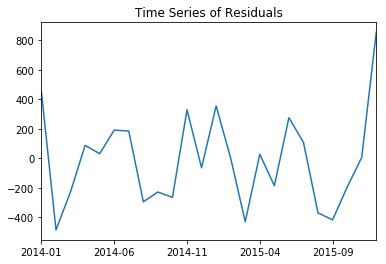

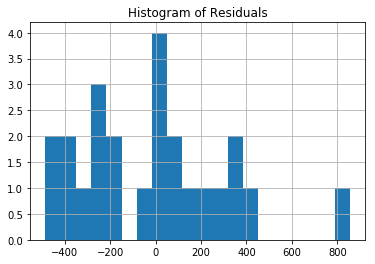

In [35]:
residuals = pd.DataFrame(count_arima_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')

#### Generic and Branded

96.8% of changes are to generic medicines.


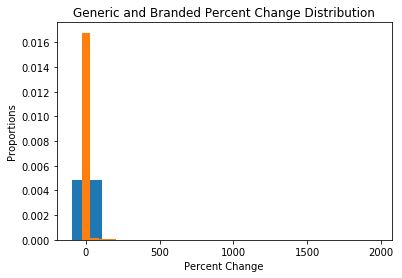

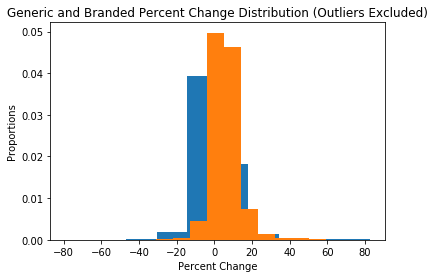

Mean Percent Change for Generic Drugs: 1.23 percentage points
Mean Percent Change for Branded Drugs: 6.29 percentage points
Standad Deviation for Generic Drugs: 27.12 percentage points
Standad Deviation for Branded Drugs: 17.64 percentage points
T-Statistic: -21.0
P-Value: 0.0


In [36]:
print('{}% of changes are to generic medicines.'.format(round(len(raw[raw['classification_for_rate_setting'] == 'G'])
                                                              / raw.shape[0], 3) * 100))

raw_generic = raw[raw['classification_for_rate_setting'] == 'G']['percent_change']
raw_branded = raw[raw['classification_for_rate_setting'] == 'B']['percent_change']

#Compare how often and the magnitude of change between generic and branded medicine.
plt.title('Generic and Branded Percent Change Distribution')
plt.hist(raw_generic, normed = True)
plt.hist(raw_branded, normed = True)

plt.xlabel('Percent Change')
plt.ylabel('Proportions')
plt.show()


plt.title('Generic and Branded Percent Change Distribution (Outliers Excluded)')
plt.hist(raw_generic[(np.abs(stats.zscore(raw_generic)) < 3)], normed = True)
plt.hist(raw_branded[(np.abs(stats.zscore(raw_branded)) < 3)], normed = True)

plt.xlabel('Percent Change')
plt.ylabel('Proportions')
plt.show()

#Print Stats
print('Mean Percent Change for Generic Drugs: {} percentage points'.format(round(raw_generic.mean() ,2)))
print('Mean Percent Change for Branded Drugs: {} percentage points'.format(round(raw_branded.mean() ,2)))

print('Standad Deviation for Generic Drugs: {} percentage points'.format(round(raw_generic.std() ,2)))
print('Standad Deviation for Branded Drugs: {} percentage points'.format(round(raw_branded.std() ,2)))

#T-test
t_stat, p_val = stats.ttest_ind(raw_generic, raw_branded)

print('T-Statistic: {}'.format(round(t_stat)))
print('P-Value: {}'.format(round(p_val)))


#### Drug Name: Record Count and Price Change

In [37]:
#Create a dataframe for every drug name
drugs = pd.DataFrame(index = raw['drug_name'].unique())

drugs['value_counts'] = raw.groupby(['drug_name']).count()['ndc']
drugs['average_price_per_unit'] = raw.groupby(['drug_name']).mean()['new_nadac_per_unit']
drugs['average_scaled_price_per_unit'] = raw.groupby(['drug_name']).mean()['scaled_new_per_unit']
drugs['average_percent_change'] = raw.groupby(['drug_name']).mean()['percent_change']

drugs.head()

,value_counts,average_price_per_unit,average_scaled_price_per_unit,average_percent_change
ALREX,11,32.704238,32.704238,4.502727
ATIVAN,63,15.226396,23.915992,15.552698
BEPREVE,11,30.788663,30.788663,5.098182
BESIVANCE,4,24.715778,24.715778,5.927500
CARDIZEM CD,174,20.366692,32.322600,11.966667


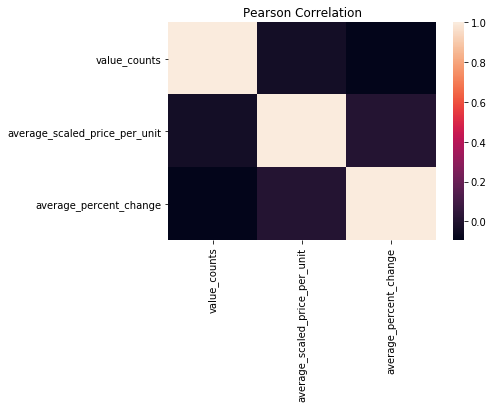

In [38]:
plt.title('Pearson Correlation')
sns.heatmap(drugs[['value_counts','average_scaled_price_per_unit', 'average_percent_change']].corr())

### Forecasting

#### Individual Drugs

__By NDC Description__

In [39]:
#Find most frequently changed ndc prices
top_n_drug_name = raw['drug_name'].value_counts().sort_values(ascending = False)[:25]

### Forecasting

#### Market Volatility

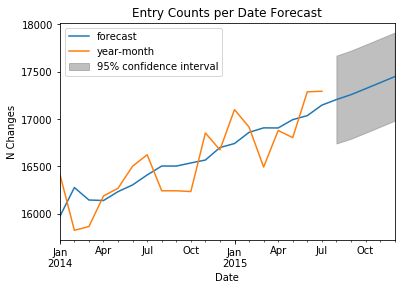

In [111]:
#Now we will forecast the next two years of monthly entry counts
#We have already trained the model on the training set, and now we can validate it on the test set.

#count_arima_fit.predict()
size = int(len(mnth_count) * TRAIN_SPLIT)
test =  mnth_count[size:len(mnth_count)]

mnth_count.sort_index()
#Create prediction array


#Create array of timestamps:

#plt.plot(mnth_count, color = 'blue')

count_arima_fit.plot_predict(start = mnth_count.index[1],end = max(mnth_count.index))
plt.title('Entry Counts per Date Forecast')
#plt.xticks(np.arange(0,len(mnth_count.index), round((len(mnth_count.index)) / 8)), rotation = 70)
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('N Changes')
plt.show()

2014-02-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2013-12-01 00:00:00
DatetimeIndex(['2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01'],
              dtype='datetime64[ns]', freq=None)
(25,)
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'float'>
2013-12-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


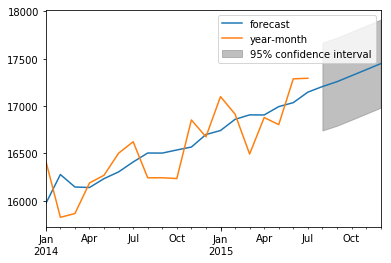

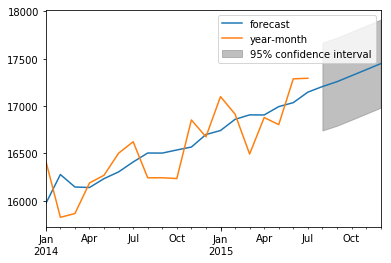

In [105]:
my_date = mnth_count.index[2]
print(my_date, type(my_date))

print(min(mnth_count.index))
print(mnth_count.index)
print(mnth_count.shape)
print(type(min(mnth_count.index)))
print(type(datetime.timestamp(min(mnth_count.index))))

print(min(mnth_count.index), type(min(mnth_count.index)))

count_arima_fit.plot_predict(start = mnth_count.index[1],end = max(mnth_count.index))

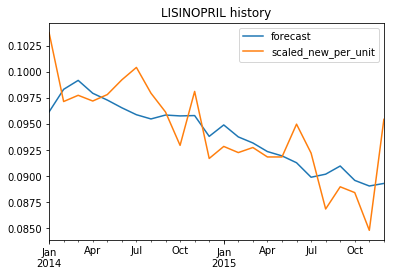

In [143]:
#LISINOPRIL
drug = 'LISINOPRIL'

drug_history = raw[raw['drug_name'] == str(drug)].groupby(['year-month']).mean()
arima_models[drug] = ARIMA(drug_history['scaled_new_per_unit'], order = (1,1,1)).fit()
    
#Plot results

arima_models[drug].plot_predict(start = drug_history.index[1],end = max(drug_history.index))
plt.title('{} history'.format(drug))
plt.show()

#### Individual Drug Names

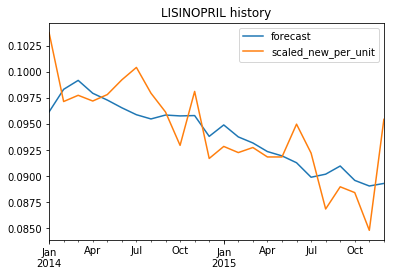

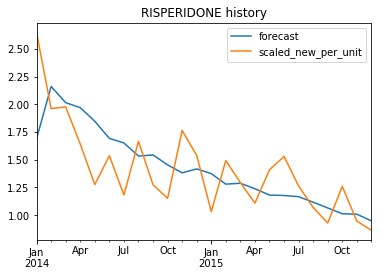

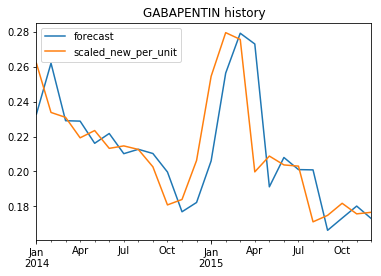

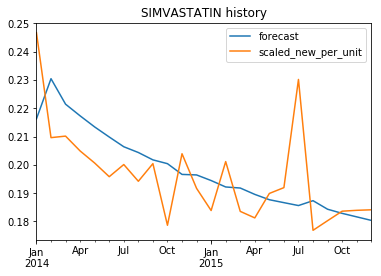

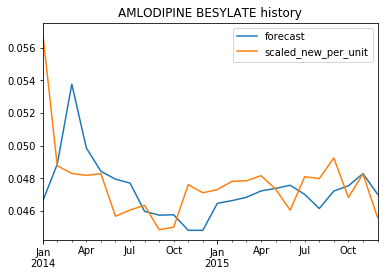

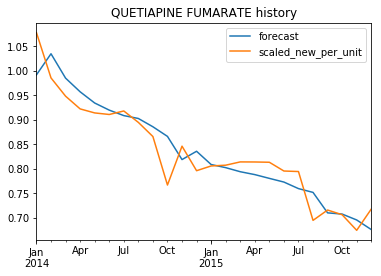

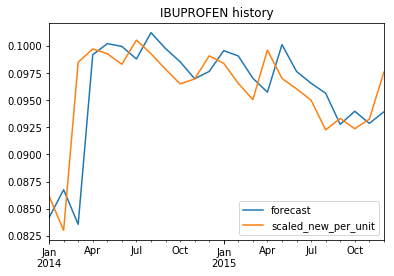

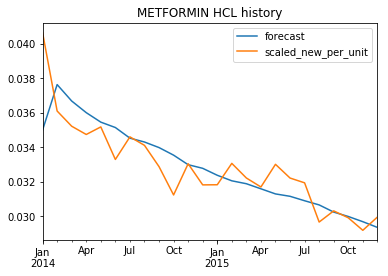

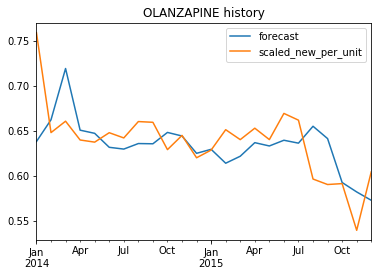

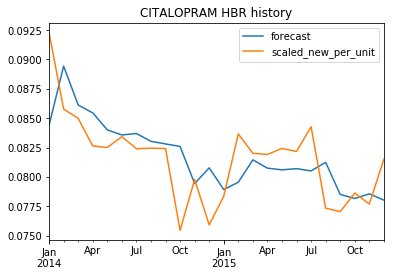

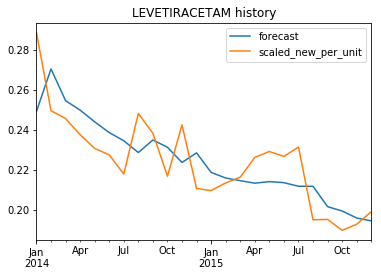

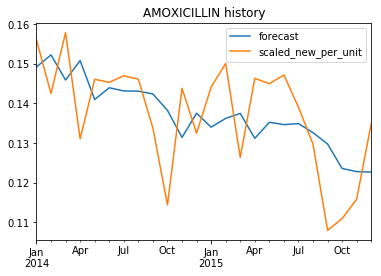

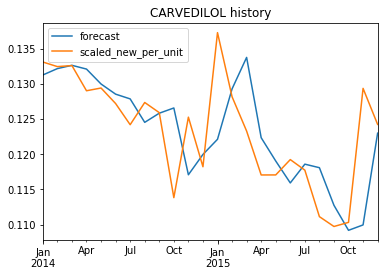

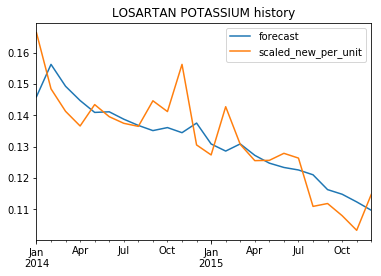

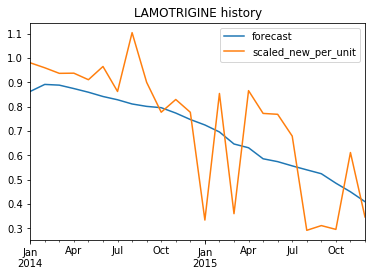

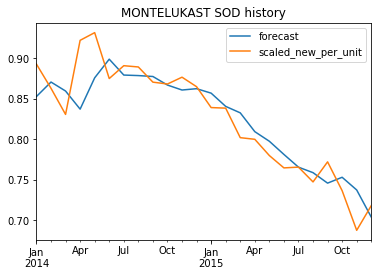

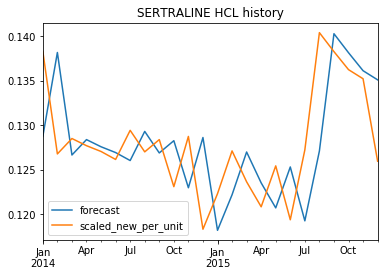

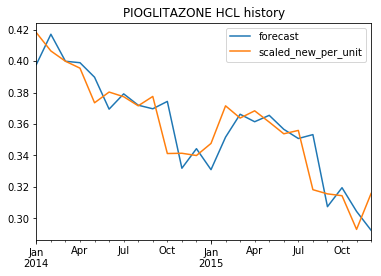

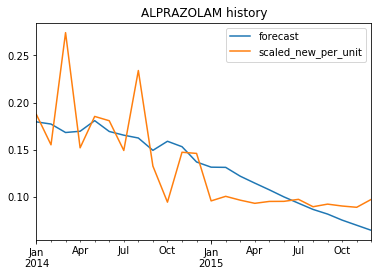

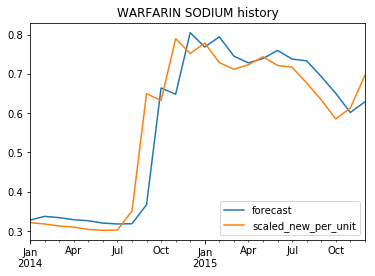

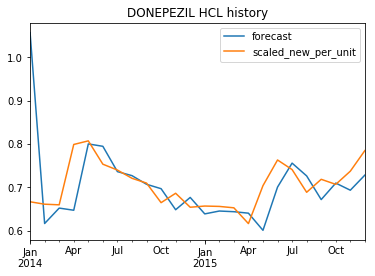

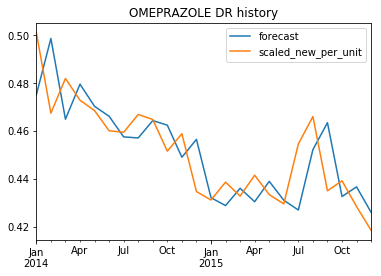

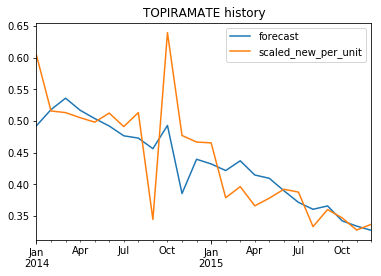

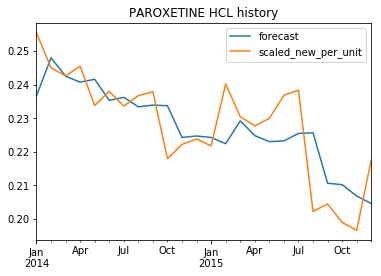

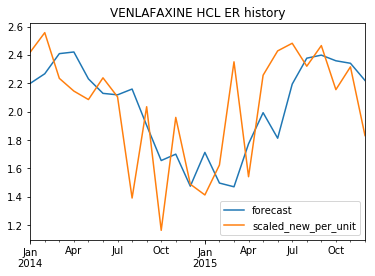

In [166]:
#Create dictionary to store models.
arima_models = {}
coefficient = []
p_value = []

#LISINOPRIL

for i, drug in enumerate(top_n_drug_name.index):
    drug_history = raw[raw['drug_name'] == str(drug)].groupby(['year-month']).mean()
    try:
        arima_models[drug] = ARIMA(drug_history['scaled_new_per_unit'], order = (1,1,1)).fit()
    #Fall through for non-stationarity
    except:
        arima_models[drug] = ARIMA(drug_history['scaled_new_per_unit'], order = (0,1,1)).fit()
    
    #Plot results
    arima_models[drug].plot_predict(start = drug_history.index[1],end = max(drug_history.index))
    plt.title('{} history'.format(drug))
    plt.show()

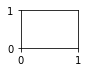

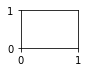

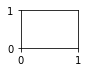

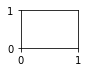

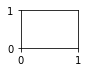

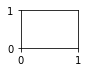

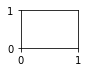

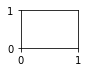

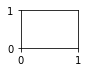

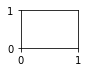

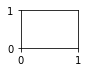

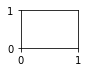

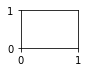

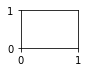

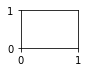

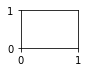

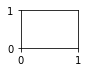

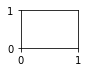

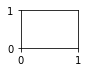

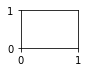

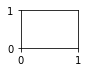

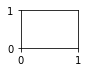

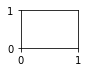

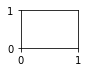

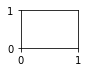

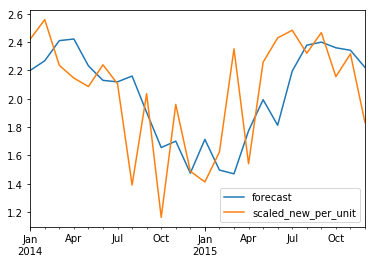

In [169]:
#Create nice visual aid
for i, drug in enumerate(top_n_drug_name.index):
    plt.subplot(5, 5, i + 1)
    arima_models[drug].plot_predict(start = drug_history.index[1],end = max(drug_history.index))
    
plt.show()
    